In [40]:
import numpy as np
import pandas as pd
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
import datetime
import yfinance as yf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from pandas import DataFrame

In [101]:
NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
start = "2021-01-01"
end = datetime.datetime.today()
symbol = 'AAPL'
df = yf.download(symbol, start = start, end = end, interval = INTERVAL).reset_index()
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.264984,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.850845,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,125.479843,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.761612,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.881653,105158200


In [102]:
print(df.head())
print(df.shape)
print(df.columns)

        Date        Open        High         Low       Close   Adj Close  \
0 2021-01-04  133.520004  133.610001  126.760002  129.410004  128.264984   
1 2021-01-05  128.889999  131.740005  128.429993  131.009995  129.850845   
2 2021-01-06  127.720001  131.050003  126.379997  126.599998  125.479843   
3 2021-01-07  128.360001  131.630005  127.860001  130.919998  129.761612   
4 2021-01-08  132.429993  132.630005  130.229996  132.050003  130.881653   

      Volume  
0  143301900  
1   97664900  
2  155088000  
3  109578200  
4  105158200  
(346, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


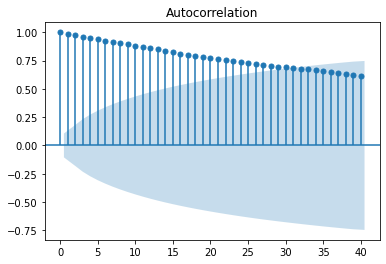

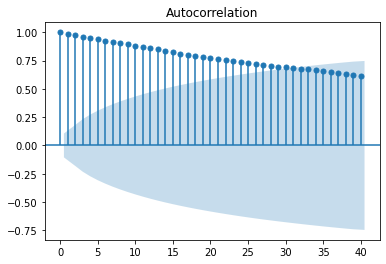

In [103]:
sm.graphics.tsa.plot_acf(df['Open'],lags=40)

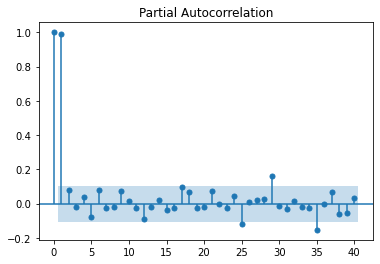

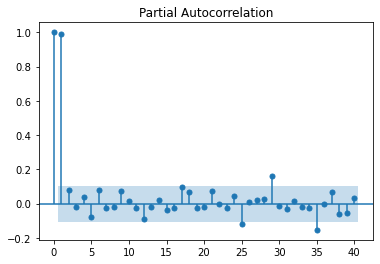

In [104]:
sm.graphics.tsa.plot_pacf(df['Open'],lags=40)

Text(0.5, 1.0, 'AAPL Autocorrelation plot')

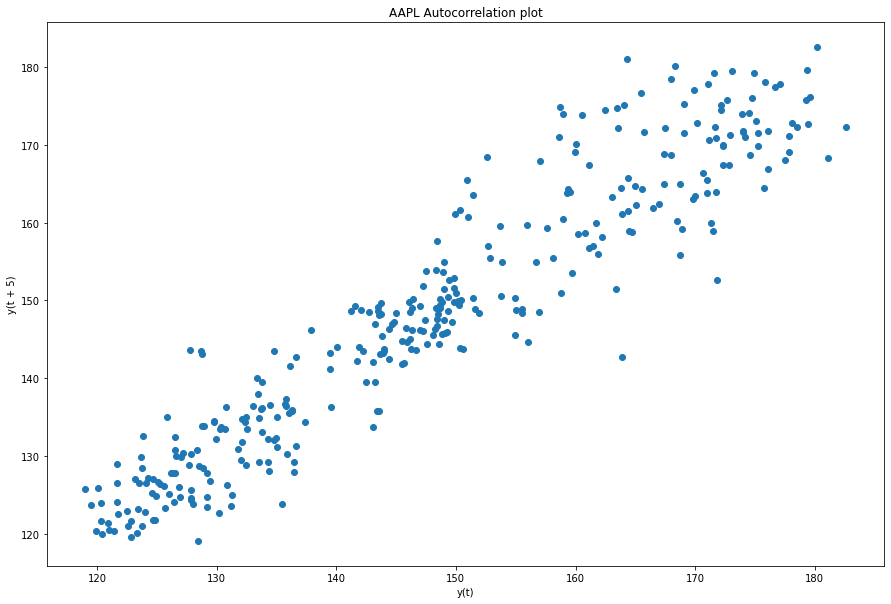

In [105]:
plt.figure(figsize=(15,10))
lag_plot(df['Open'],lag=5)
plt.title(symbol + " Autocorrelation plot")

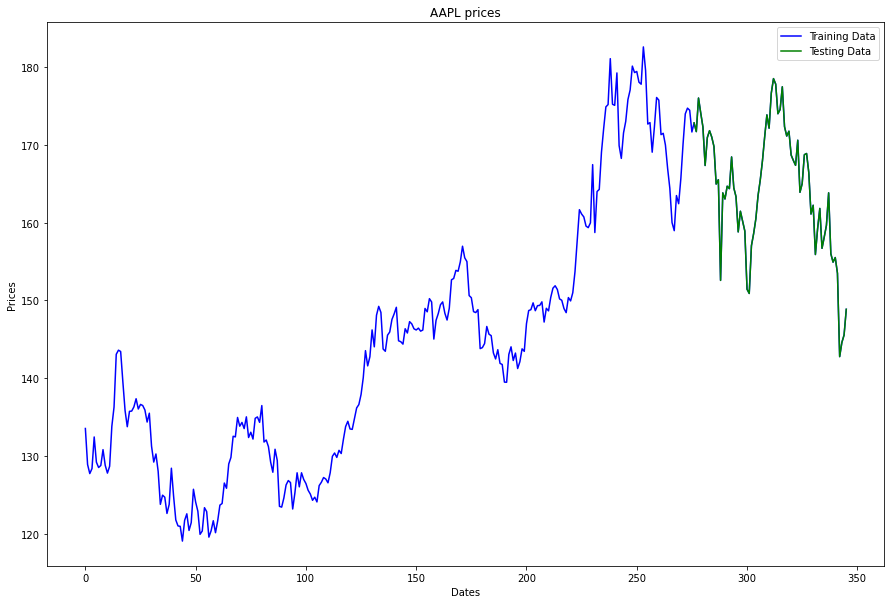

In [106]:
train_data, test_data = df[0:int(len(df)*0.8)],df[int(len(df)*0.8):]
plt.figure(figsize=(15,10))
plt.title(symbol + " prices")
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Open'],'blue', label='Training Data')
plt.plot(test_data['Open'],'green', label='Testing Data')

plt.legend()

In [18]:
def smape_kun(y_true,y_pred):
    return np.mean((np.abs(y_pred-y_true)*200/(np.abs(y_pred)+np.abs(y_true))))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28566D+00    |proj g|=  5.17906D-03

At iterate    5    f=  2.28552D+00    |proj g|=  3.10862D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7      9      1     0     0   4.441D-08   2.286D+00
  F =   2.2855170798344555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/tyler._.bui/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


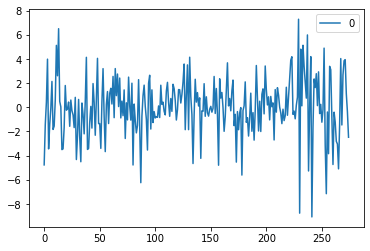

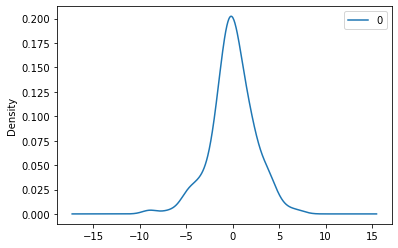

In [107]:
# check for resid plot and resid density plot to make sure it follows gaussian density

train_ar = np.nan_to_num(train_data['Open'].values)

model = sm.tsa.ARIMA(train_ar, order=(5,1,0))
model_fit = model.fit()

residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

In [50]:

test_ar = np.nan_to_num(test_data['Open'].values)

history = [x for x in train_ar]

predictions = list()
for t in range(len(test_ar)):
    model = sm.tsa.ARIMA(endog=history, order=(5,1,0))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)

error = mean_squared_error(test_ar, predictions)
print('Teting Mean Squared Error: %.3f' % error)

error2 = smape_kun(test_ar, predictions)
print("Symmetric mean absolute percentage error: %.3f" % error2)




/Users/tyler._.bui/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Teting Mean Squared Error: 7.660
Symmetric mean absolute percentage error: 13.785


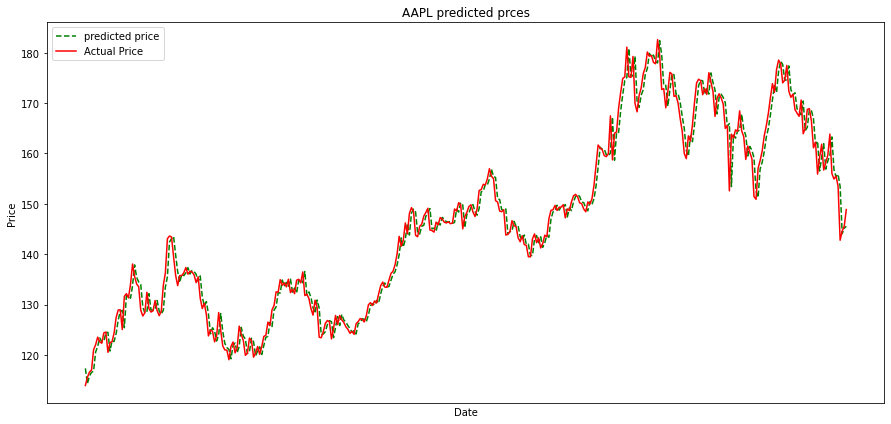

In [51]:
plt.figure(figsize = (15,7))
plt.plot(test_data.index,predictions, color="green", linestyle='dashed',label='predicted price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.xticks(np.arange(1486,100,90),df['Date'][1486:100:90])
plt.title(symbol + ' predicted prces')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [ ]:
# backtest : apply money. 

In [56]:
DataFrame(history[:10], predictions[:10])

ValueError: Shape of passed values is (10, 1), indices imply (1, 1)

In [89]:
df1 = pd.DataFrame(test_ar[:10])
df1.rename(columns = {0:'Observations'}, inplace=True)

df2 = pd.DataFrame(predictions[:10])
df2.rename(columns = {0:'Predictions'}, inplace=True)



In [94]:
results = pd.concat([df1,df2],axis=1)

In [95]:
print(results)

   Observations  Predictions
0    113.910004   117.311091
1    115.550003   114.282812
2    116.570000   115.820045
3    116.970001   116.520973
4    121.010002   116.764735
5    122.019997   120.554664
6    123.519997   121.676793
7    122.599998   123.349368
8    122.309998   122.590528
9    124.370003   122.655220
